In [1]:
import gymnasium as gym

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

from tqdm.notebook import tqdm
from collections import namedtuple
from collections import deque
import random

In [2]:
# Define the (state) value network
class V_net(________):
    # Initialise the network
    def __init__(self, env):
        # Call the parent class
        super(V_net, self).__init__()
        # Set the input and output size
        self.obs_dim = env.observation_space.shape[0]
        # Define the layers of the network
        self.layers = nn.Sequential(
            
        )
    
    def forward(self, x):
        

In [3]:
# Define the policy network
class policy_net(_______):
    # Initialise the network
    def __init__(self, env):
        # Call the parent class
        super(policy_net, self).__init__()
        # Set the input and output size
        self.obs_dim = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        # Define the layers of the network
        self.layers = nn.Sequential(
            
        )
    
    def _______(self, x):
        return self.layers(x)

In [4]:
# Define the interact function
def interact(agent, env, steps):
    # Initialise the data storage 
    batch = []
    # Initialise the returns list
    return_list = []
    # Initialize the state
    state, _ = env.reset()
    # Initialize the episode return
    episode_return = 0
    for _ in range(steps):    
        # Create a dictionary to store the datapoint
        data = {"state":state}
        # Choose the action 
        action = agent.sample_action(state)
        data["action"] = action
        # Perform the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        data["reward"] = reward
        data["next_state"] = next_state
        data["terminated"] = terminated
        episode_return += reward
        batch.append(data) 
        # Update the state
        state = next_state
        # Check if the episode is over
        if terminated or truncated:
            # Store the episode reward
            return_list.append(episode_return)
            # Reset the episode reward
            episode_return = 0
            # Reset the environment
            state, _ = env.reset()
    return batch, return_list

In [5]:
def train_value_network(batch, agent, num_iterations, minibatch_size = 32): 
    # Iterate through the batch and form the regression targets using the truncated one-step return
    for point in batch:
        reward = point["reward"]
        next_state = torch.tensor(point["next_state"], dtype=torch.float32)
        terminated = point["terminated"]
        with torch.no_grad():
            point["regression_target"] = ____________________

    # Perform num_iterations gradient updates 
    for ii in range(num_iterations):
        # Sample a minibatch of data from the batch
        minibatch = random.sample(batch, minibatch_size)
        # Convert the data to tensors
        states = torch.tensor(np.array([point["state"] for point in minibatch]))
        regression_targets = torch.tensor([point["regression_target"] for point in minibatch], dtype=torch.float32)
        # Compute the value predictions
        value_predictions = ____________
        # Compute the loss
        loss = _________(value_predictions, regression_targets.unsqueeze(dim=1))
        # Zero the gradients
        __________________
        # Compute the gradients
        __________________
        # Update the weights
        __________________

In [6]:
def train_policy_network(batch, agent):
    # Create the policy objective
    J = 0
    # Iterate through the batch and form the regression targets using the TD error
    for point in batch:
        state = torch.tensor(point["state"], dtype=torch.float32)
        action = point["action"]
        reward = torch.tensor(point["reward"], dtype=torch.float32)
        next_state = torch.tensor(point["next_state"], dtype=torch.float32)
        terminated = point["terminated"]
        with torch.no_grad():
            # Compute the advantage
            advantage = ______________________
        
        log_prob = _________________

        J += ________________
    
    # Divide J by the number of datapoints in the batch
    J = J/len(batch)

    # Add on an L2 regularisation term
    l2_reg = 0
    for param in agent.policy_network.parameters():
        l2_reg += torch.norm(param)**2
    J = J - agent.l2_coeff*l2_reg
    
    # Zero the gradients
    ________________
    # Compute the gradients
    ________________
    # Update the weights
    ________________        

In [7]:
# Define the agent
class A2C_agent():
    # Initialise the agent
    def __init__(self, env, gamma = 0.97, value_lr = 0.001, policy_lr = 0.001, l2_coeff = 0.0001):
        # Set the discount factor
        self.gamma = gamma
        # Set the L2 regularisation coefficient
        self.l2_coeff = l2_coeff
        # Create the value network
        self.value_network = ______
        # Create the policy network
        self.policy_network = ______
        # Create the optimizers
        self.value_optimizer = _______________________
        self.policy_optimizer = ______________________
    
    # Define the sample action function
    def sample_action(self, state):
        # Convert the state to a tensor
        state = torch.tensor(state, dtype=torch.float32)
        # Compute the action probabilities
        action_probs = self.policy_network(state).detach().numpy()
        # Sample the action
        action = np.random.choice(len(action_probs), p=action_probs)
        return action

In [8]:
def train_loop(agent, env, num_epochs, steps_per_epoch=1000):
    # Create a list to store all the rewards
    all_returns = []
    # Loop over the number of epochs
    for epoch in tqdm(range(num_epochs)):
        # Interact with the environment
        batch, return_list = interact(agent, env, steps_per_epoch)
        # Train the value network
        train_value_network(batch, agent, num_iterations=100)
        # Train the policy network
        train_policy_network(batch, agent)
        # Store the rewards
        all_returns.extend(return_list)
    return all_returns

In [9]:
# Plot the returns
def plot_returns(return_list):
    plt.xlabel('Episode number')
    plt.plot(return_list)
    plt.ylabel('Return')
    plt.xlim(0, len(return_list))
    plt.ylim(0.9*min(return_list), 1.1*max(return_list))
    plt.show()

In [10]:
# Define the visualise function
# This displays the agent's behaviour in the environment for 500 steps.  
def visualise(agent, env, n_steps):
    # Reset the environment
    state, _ = env.reset()

    # Initialise the list of frames   
    frames = []

    for _ in range(n_steps):
        # Render the environment and store the frame
        frames.append(env.render())

        # Take an action 
        action = agent.sample_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        # Update the state
        state = next_state
        # Check if the episode is over
        if terminated or truncated:
            state, _ = env.reset()

    # Display the movie
    for frame in frames:
        clear_output(wait=True)
        plt.imshow(frame)
        plt.show()
        sleep(0.003)

In [11]:
# Create the environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
# Create the agent
agent = A2C_agent(env)

In [12]:
return_list = train_loop(agent, env, num_epochs=150, steps_per_epoch=1000)

  0%|          | 0/150 [00:00<?, ?it/s]

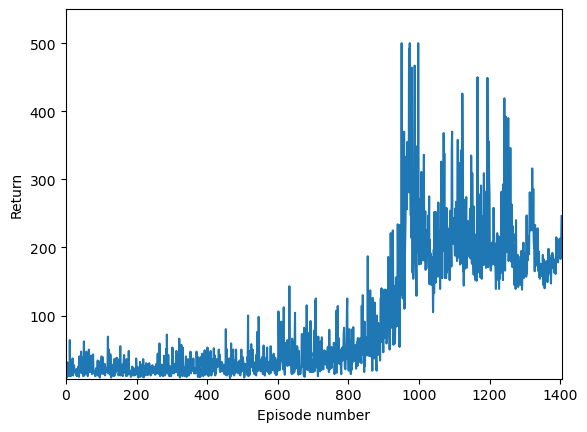

In [13]:
plot_returns(return_list)

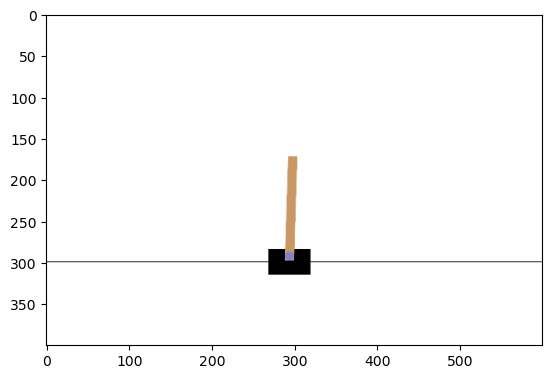

In [14]:
# Visualise the agent's behaviour
visualise(agent, env, 500)

In [15]:
len(return_list)

1405